<a href="https://colab.research.google.com/github/jingairpi/llm.jax/blob/main/notebooks/llm.jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/jingairpi/llm.jax.git

%cd llm.jax
!pip install -e .

!pip install tiktoken

fatal: destination path 'llm.jax' already exists and is not an empty directory.
/content/llm.jax
Obtaining file:///content/llm.jax
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for llm-jax (pyproject.toml) ... done
  Created wheel for llm-jax: filename=llm_jax-0.1.0-py3-none-any.whl size=2007 sha256=b30aab5f144b1bab80988fe4047758caa2351d8ea93c94ae056b006163b2a96b
  Stored in directory: /tmp/pip-ephem-wheel-cache-man0rd3w/wheels/f5/45/9b/9974346d34cbb3b99a739447c080dfbe67d48b90c92e1b3961
Successfully built llm-jax
  Attempting uninstall: llm-jax
    Found existing installation: llm-jax 0.1.0
    Uninstalling llm-jax-0.1.0:
      Successfully uninstalled llm-jax-0.1.0


In [2]:
import requests
import numpy as np
import tiktoken

# Download Tiny Shakespeare.
url = "https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt"
response = requests.get(url)
text = response.text

# Get GPT-2 encoding.
enc = tiktoken.get_encoding("gpt2")

# Encode the text into token IDs.
tokens = enc.encode(text)
tokens = np.array(tokens, dtype=np.int32)

# Save tokens to a binary file.
with open("tiny_shakespeare.bin", "wb") as f:
    tokens.tofile(f)

print(f"Saved {len(tokens)} tokens to tiny_shakespeare.bin")

Saved 338025 tokens to tiny_shakespeare.bin


Starting training for 1000 steps...
Step 0: Training Loss = 10.8279, Eval Loss = 10.5035
Step 100: Training Loss = 2.6002, Eval Loss = 5.3601
Step 200: Training Loss = 0.2409, Eval Loss = 6.0209
Step 300: Training Loss = 0.0393, Eval Loss = 6.5847
Step 400: Training Loss = 0.0188, Eval Loss = 6.8582
Step 500: Training Loss = 0.0118, Eval Loss = 7.0342
Step 600: Training Loss = 0.0083, Eval Loss = 7.1668
Step 700: Training Loss = 0.0064, Eval Loss = 7.2745
Step 800: Training Loss = 0.0051, Eval Loss = 7.3663
Step 900: Training Loss = 0.0043, Eval Loss = 7.4468
Training complete.


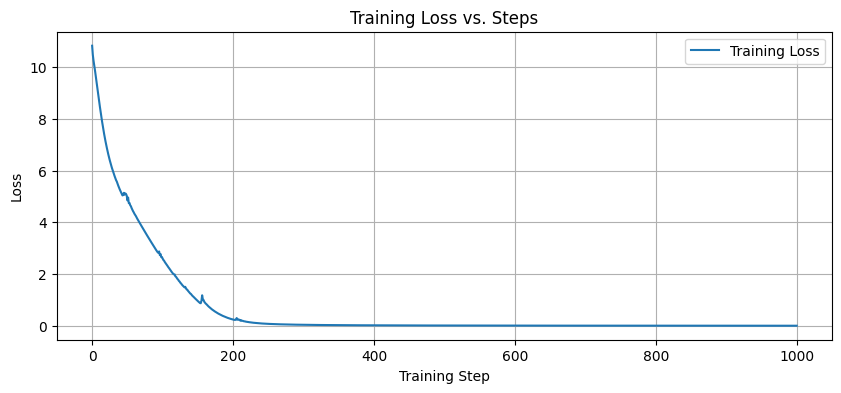

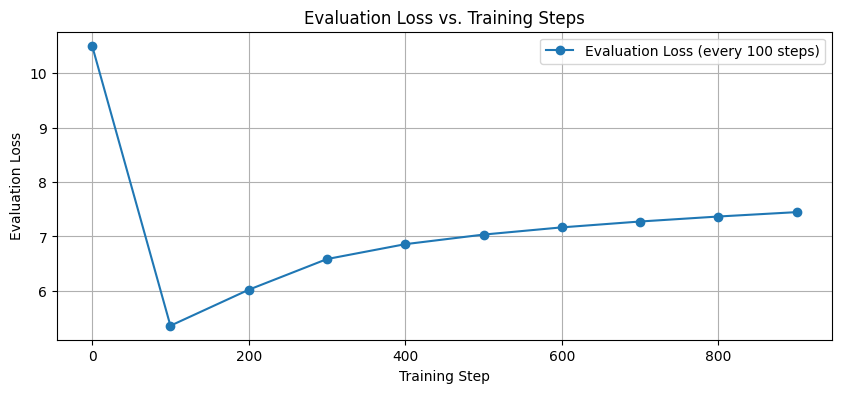

In [3]:
import jax
import jax.numpy as jnp
import tiktoken
import matplotlib.pyplot as plt

from llm.config import GPT2Config
from llm.data import DataLoader
from llm.model import GPT2Model
from llm.trainer import Trainer
from llm.evaluator import Evaluator

# -----------------------------------------------------------------------------
# Define a smaller GPT-2 model configuration (for resource constraints)
config = GPT2Config(
    vocab_size=50257,  # Standard GPT-2 vocabulary size
    n_positions=256,   # Use a shorter sequence length for training and inference
    n_embd=128,        # Smaller embedding dimension
    n_layer=2,         # Two transformer blocks
    n_head=2,          # Two attention heads
)

# Instantiate the model.
model = GPT2Model(config)

# Define optimizer configuration.
optimizer_config = {
    "learning_rate": 1e-3,
    "batch_size": 32,  # Adjust based on your available GPU memory
}

# Use a sequence length that matches your model's n_positions.
seq_len = 256

# Create a DataLoader instance for training (repeat enabled).
train_loader = DataLoader("tiny_shakespeare.bin", optimizer_config["batch_size"], seq_len, repeat=True)

# Create a separate DataLoader for evaluation (repeat disabled).
eval_loader = DataLoader("tiny_shakespeare.bin", optimizer_config["batch_size"], seq_len, repeat=False)

# Create a random number generator key.
rng = jax.random.PRNGKey(0)

# Instantiate your Trainer.
trainer = Trainer(model, config, optimizer_config, train_loader, rng)

# Instantiate Evaluator.
evaluator = Evaluator(model, eval_loader)

# -----------------------------------------------------------------------------
# Training: Run the training loop for 1000 steps, record losses, and evaluate every 100 steps.
print("Starting training for 1000 steps...")

num_steps = 1000
losses = []      # To store training loss per step.
eval_losses = [] # To store evaluation loss every 100 steps.
steps_list = []  # Step numbers at which evaluation is performed.

step = 0
while step < num_steps:
    batch = next(iter(train_loader))
    trainer.rng, step_rng = jax.random.split(trainer.rng)
    trainer.state, loss, logits = trainer.train_step(trainer.state, batch, step_rng)
    losses.append(float(loss))

    if step % 100 == 0:
        eval_loss = evaluator.evaluate(trainer.state.params, num_steps=5)
        eval_losses.append(eval_loss)
        steps_list.append(step)
        print(f"Step {step}: Training Loss = {loss:.4f}, Eval Loss = {eval_loss:.4f}")
    step += 1

print("Training complete.")

# -----------------------------------------------------------------------------
# Plot the training loss.
plt.figure(figsize=(10, 4))
plt.plot(losses, label="Training Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.title("Training Loss vs. Steps")
plt.legend()
plt.grid(True)
plt.show()

# Plot the evaluation loss.
plt.figure(figsize=(10, 4))
plt.plot(steps_list, eval_losses, 'o-', label="Evaluation Loss (every 100 steps)")
plt.xlabel("Training Step")
plt.ylabel("Evaluation Loss")
plt.title("Evaluation Loss vs. Training Steps")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
from llm.inferencer import Inferencer

# -----------------------------------------------------------------------------
# Inference: Generate text using the trained model.
inferencer = Inferencer(model, config)

# Use tiktoken to encode an input prompt.
enc = tiktoken.get_encoding("gpt2")
prompt_text = "what is the meaning of life?"
prompt_ids = enc.encode(prompt_text)
# Convert the prompt into a 2D JAX array (batch_size = 1).
initial_prompt = jnp.array([prompt_ids], dtype=jnp.int32)

# Generate additional tokens (e.g., 32 new tokens).
generated_ids = inferencer.generate(trainer.state.params, initial_prompt, max_new_tokens=32, temperature=1.0, top_k=40, rng_key=trainer.rng)
# Decode the entire sequence (prompt + generated tokens).
generated_tokens = generated_ids[0].tolist()
decoded_text = enc.decode(generated_tokens)

print("Prompt:", prompt_text)
print("Generated text:", decoded_text)

Prompt: what is the meaning of life?
Generated text: what is the meaning of life? granted them by calam
ThatThat know and hear hither things he rather o'ThoughThough you.
And know't
Thataks withre'TrueThat
